In [1]:
import pysal as ps
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px

from math import ceil

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from esda.adbscan import ADBSCAN

from scipy.cluster.hierarchy import dendrogram

import spopt
from spopt.region import MaxPHeuristic as MaxP
import matplotlib.pyplot as plt

import libpysal
import warnings

/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

In [2]:
# Load the datasets
imd_england_df = pd.read_csv('Data/imd_england_lsoa.csv')
london_lsoa_df = pd.read_csv('Data/LSOA2011 AvPTAI2015.csv')

# Merge the datasets on 'lsoa_code'
merged_df = pd.merge(london_lsoa_df, imd_england_df, on='lsoa_code', how='inner')

# Display the first few rows of the merged dataframe
print(merged_df.head())

   lsoa_code  AvPTAI2015 PTAL  PTAIHigh  PTAILow  IMD_decile  Income_decile  \
0  E01000001     69.8233   6b   97.4435  35.9190           9             10   
1  E01000002     83.7820   6b  117.9120  66.3503          10             10   
2  E01000003     41.7417   6b   49.5318  37.3635           5              6   
3  E01000005     85.8893   6b  120.8470  45.9168           3              2   
4  E01000006     22.4558    5   34.1054   0.0000           5              5   

   Employment_decile  Education_decile  Health_decile  ...  \
0                 10                10             10  ...   
1                 10                10             10  ...   
2                  5                 9              6  ...   
3                  3                 4              6  ...   
4                  7                 6              7  ...   

   Housing_and_Access_decile  Environment_decile  IMD_rank  Income_rank  \
0                          3                   3     29199        32831   
1 

In [3]:
# Drop the specified columns
columns_to_drop = [
    'PTAL', 'PTAIHigh', 'PTAILow', 'IMD_rank', 'Income_rank',
    'Employment_rank', 'Education_rank', 'Health_rank',
    'Crime_rank', 'Housing_and_Access_rank', 'Environment_rank'
]
filtered_df = merged_df.drop(columns=columns_to_drop)

# Check for missing values
print(filtered_df.isnull().sum())

# Display the dataframe
print(filtered_df)

lsoa_code                    0
AvPTAI2015                   0
IMD_decile                   0
Income_decile                0
Employment_decile            0
Education_decile             0
Health_decile                0
Crime_decile                 0
Housing_and_Access_decile    0
Environment_decile           0
dtype: int64
      lsoa_code  AvPTAI2015  IMD_decile  Income_decile  Employment_decile  \
0     E01000001    69.82330           9             10                 10   
1     E01000002    83.78200          10             10                 10   
2     E01000003    41.74170           5              6                  5   
3     E01000005    85.88930           3              2                  3   
4     E01000006    22.45580           5              5                  7   
...         ...         ...         ...            ...                ...   
4830  E01033742     3.95321           7              7                  9   
4831  E01033743     3.81744           5              4       

In [4]:
gdf = gpd.read_file("Data/statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp")
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LSOA11CD   4835 non-null   object  
 1   LSOA11NM   4835 non-null   object  
 2   MSOA11CD   4835 non-null   object  
 3   MSOA11NM   4835 non-null   object  
 4   LAD11CD    4835 non-null   object  
 5   LAD11NM    4835 non-null   object  
 6   RGN11CD    4835 non-null   object  
 7   RGN11NM    4835 non-null   object  
 8   USUALRES   4835 non-null   int64   
 9   HHOLDRES   4835 non-null   int64   
 10  COMESTRES  4835 non-null   int64   
 11  POPDEN     4835 non-null   float64 
 12  HHOLDS     4835 non-null   int64   
 13  AVHHOLDSZ  4835 non-null   float64 
 14  geometry   4835 non-null   geometry
dtypes: float64(2), geometry(1), int64(4), object(8)
memory usage: 566.7+ KB


In [5]:
# Merge dataframes on a common key
combined_data = pd.merge(filtered_df, gdf, left_on='lsoa_code', right_on='LSOA11CD', how='inner')
combined_data = gpd.GeoDataFrame(combined_data, geometry='geometry')
combined_data.shape

(4835, 25)

### Raw Distribution

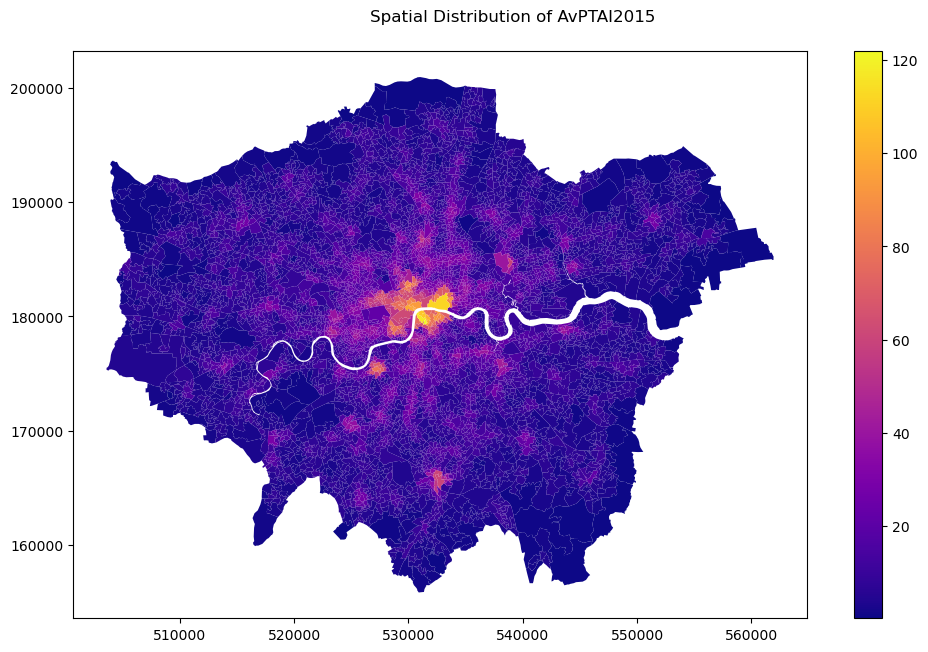

In [6]:
f = plt.figure()
f.set_size_inches(12,7)

ax1 = f.add_subplot()
combined_data.plot(column='AvPTAI2015', legend=True, cmap='plasma', figsize=(12,6), ax=ax1)

f.subplots_adjust(top=0.92)
f.suptitle("Spatial Distribution of AvPTAI2015");
plt.savefig('Cluster-Accessibilitylevel-Raw.png', dpi=150)

## Variable Selection and Standardisation

In [7]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rs = RobustScaler(quantile_range=(10.0, 90.0))

In [8]:
combined_data.head()

,lsoa_code,AvPTAI2015,IMD_decile,Income_decile,Employment_decile,Education_decile,Health_decile,Crime_decile,Housing_and_Access_decile,Environment_decile,...,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E01000001,69.8233,9,10,10,10,10,10,3,3,...,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,83.7820,10,10,10,10,10,10,4,4,...,City of London,E12000007,London,1436,1436,0,62.9,830,1.7,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,41.7417,5,6,5,9,6,9,1,2,...,City of London,E12000007,London,1346,1250,96,227.7,817,1.5,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,85.8893,3,2,3,4,6,10,1,3,...,City of London,E12000007,London,985,985,0,52.0,467,2.1,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,22.4558,5,5,7,6,7,6,1,4,...,Barking and Dagenham,E12000007,London,1703,1699,4,116.2,543,3.1,"POLYGON ((545122.049 184314.931, 545271.917 18..."


# Here we focus on:
IMD_decile
AvPTAI2015
Income_decile
Education_decile
and also lsoa_code

In [9]:
raw = combined_data[['lsoa_code','AvPTAI2015','IMD_decile', 'Income_decile','Education_decile']].set_index('lsoa_code').copy()
raw.head()

,AvPTAI2015,IMD_decile,Income_decile,Education_decile
lsoa_code,,,,
E01000001,69.8233,9,10,10
E01000002,83.7820,10,10,10
E01000003,41.7417,5,6,9
E01000005,85.8893,3,2,4
E01000006,22.4558,5,5,6


<Axes: ylabel='Frequency'>

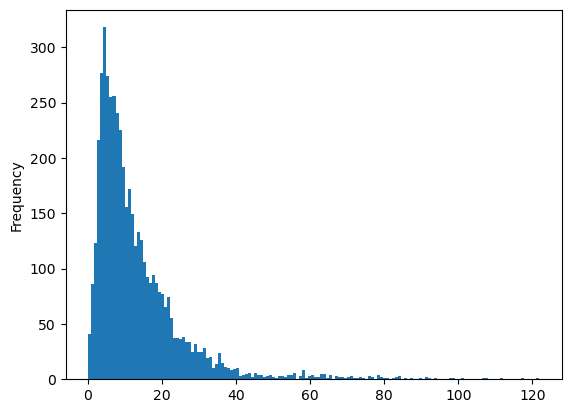

In [10]:
raw.AvPTAI2015.plot.hist(bins=150)

In [11]:
normed = raw.copy()
for c in raw.columns.values:
    normed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))
normed.head()

The range of AvPTAI2015 is [-0.3990650030192672, 4.809785730464945]
The range of IMD_decile is [-0.5714285714285714, 0.7142857142857143]
The range of Income_decile is [-0.42857142857142855, 0.8571428571428571]
The range of Education_decile is [-0.8571428571428571, 0.42857142857142855]


,AvPTAI2015,IMD_decile,Income_decile,Education_decile
lsoa_code,,,,
E01000001,2.581345,0.571429,0.857143,0.428571
E01000002,3.178808,0.714286,0.857143,0.428571
E01000003,1.379390,0.000000,0.285714,0.285714
E01000005,3.269005,-0.285714,-0.285714,-0.428571
E01000006,0.553911,0.000000,0.142857,-0.142857


Make a scatter plot between AvPTAI2015 (on the y axis) and IMD_decile (on the x axis).

Think about this question: is it that the higher IMD, the higher transport accessibility?

<Axes: xlabel='IMD_decile', ylabel='AvPTAI2015'>

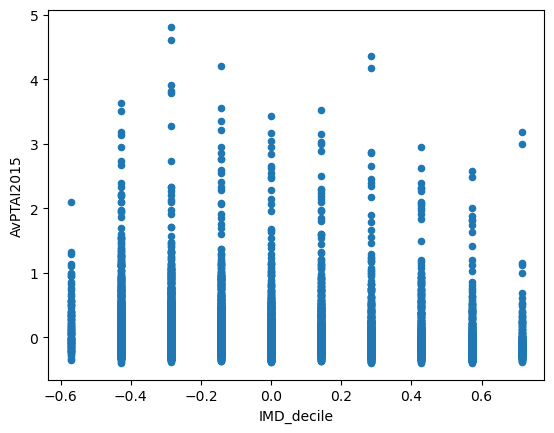

In [12]:
normed.plot.scatter(x= 'IMD_decile', y='AvPTAI2015')

# Functions

In [13]:
def mapping_clusters(labels_cluster):
    combined_data['cluster_nm'] = labels_cluster
    combined_data.plot(column='cluster_nm', categorical=True, legend=True, figsize=(12,8), cmap='Paired');

In [40]:
# adapted from this tutorial: https://towardsdatascience.com/how-to-make-stunning-radar-charts-with-python-implemented-in-matplotlib-and-plotly-91e21801d8ca
def radar_plot_cluster_centroids(df_cluster_centroid):
    # parameters
    # df_cluster_centroid: a dataframe with rows representing a cluster centroid and columns representing variables
    
    # add an additional element to both categories and restaurants that’s identical to the first item
    # manually 'close' the line
    categories = df_cluster_centroid.columns.values.tolist()
    categories = [*categories, categories[0]]
    
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    
    plt.figure(figsize=(7, 5))
    plt.subplot(polar=True)
    for index, row in df_cluster_centroid.iterrows():
        centroid = row.tolist()
        centroid = [*centroid, centroid[0]]
        label = "Cluster {}".format(index)
        plt.plot(label_loc, centroid, label=label)
    plt.title('Cluster centroid comparison', size=20, y=1.05)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    plt.legend()
    plt.show()

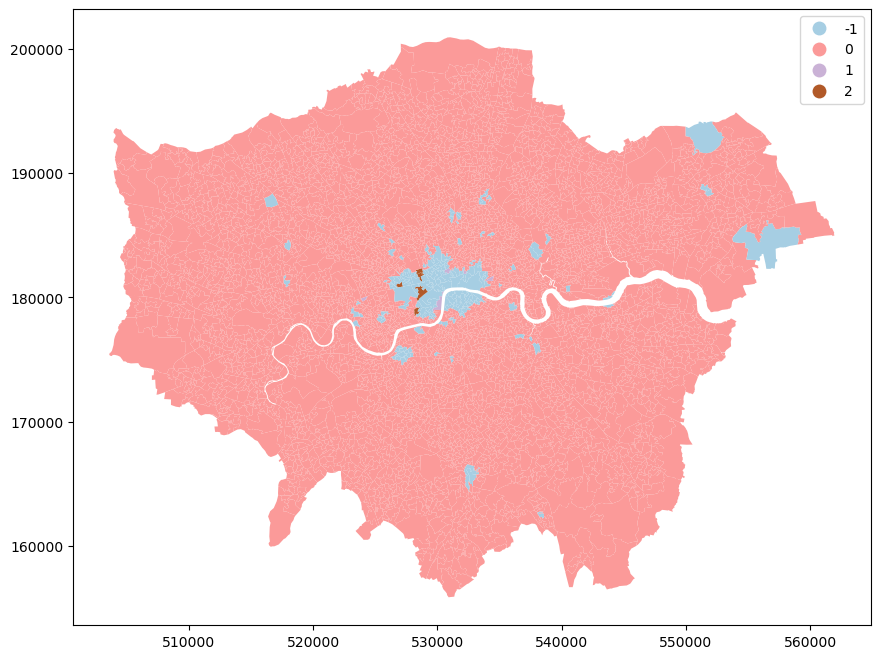

In [15]:
# dbscan
minPts = 5 # we set minPts as normed.shape[1] + 1 
epsilon = 0.2
dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
dbsc.fit(normed)

# We now have our DBSCAN object created, and we can extract the groups it has identified. We do this using the `.labels_` method.
cluster_nm = dbsc.labels_

mapping_clusters(cluster_nm)
plt.savefig('dbscan.png', dpi=150)

In [16]:
pd.Series(dbsc.labels_).value_counts()

 0    4636
-1     189
 1       5
 2       5
Name: count, dtype: int64

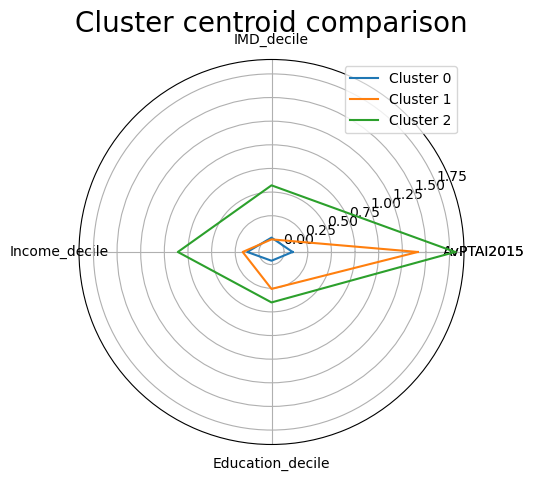

In [41]:
df_dbscan = normed.copy()
df_dbscan['cluster'] = dbsc.labels_
df_dbscan_centroid = df_dbscan.groupby('cluster').mean()
# drop the outlier
df_dbscan_centroid.drop(-1, inplace=True)
# df_dbscan_centroid.reset_index()
radar_plot_cluster_centroids(df_dbscan_centroid)

**So what do you think of the results? Do the clusters look useful or realistic?**

In [18]:
from sklearn import metrics
metrics.silhouette_score(normed, dbsc.labels_)

0.3373954331089462

In [19]:
#K-means

In [20]:
from sklearn.cluster import KMeans

In [21]:
#from dbscan, there might be 3 clusters

In [22]:
k_cluster = 3
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed)

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=1)

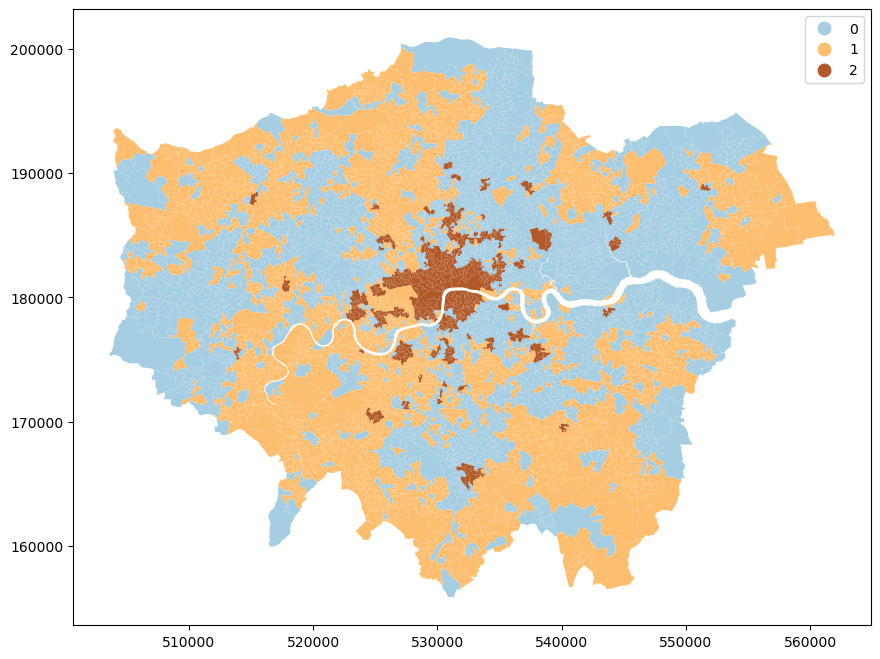

In [23]:
mapping_clusters(kmeans_method.labels_);
plt.savefig('kmeans.png', dpi=150)

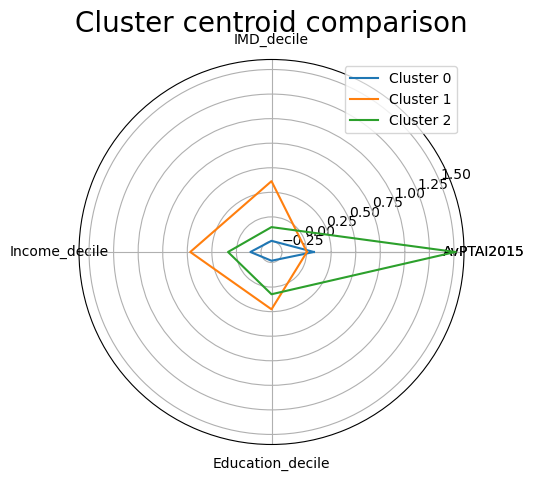

In [42]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=normed.columns)
radar_plot_cluster_centroids(df_cluster_centroid)

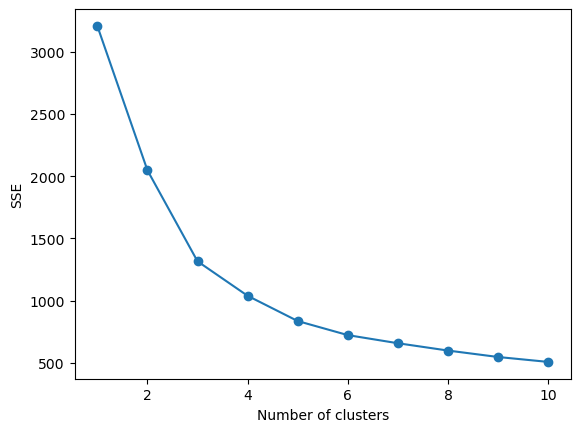

In [43]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(normed)
    # inertia is a concept from physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [26]:
k_cluster = 3
random_seed = 123
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
x_transformed = kmeans_method.fit_transform(normed)
print(normed.shape)
print(normed.columns)
# print(kmeans_method.labels_)
print(x_transformed.shape)

for centroid in kmeans_method.cluster_centers_:
    print(np.linalg.norm(np.array(normed)[0] - centroid))
print(x_transformed[0])

(4835, 4)
Index(['AvPTAI2015', 'IMD_decile', 'Income_decile', 'Education_decile'], dtype='object')
(4835, 3)
2.904204452126853
2.6230390080980284
1.5227644348935063
[2.90420445 2.62303901 1.52276443]


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


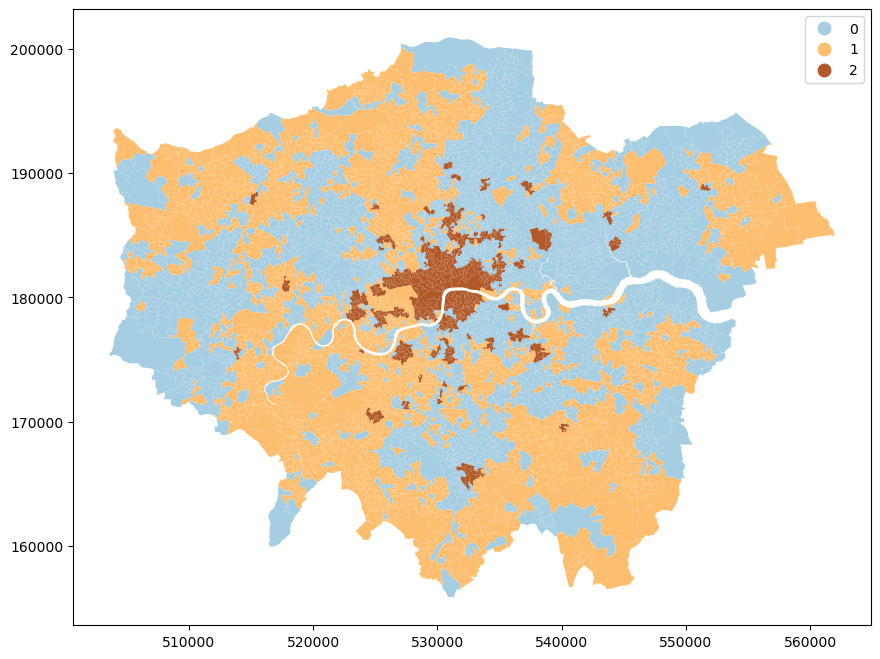

In [27]:
k_cluster = 3
random_seed = 123
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed)

# plotting
mapping_clusters(kmeans_method.labels_)
plt.savefig('kmeans2.png', dpi=150)

In [28]:
#Hierachical clustering
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, leaf_rotation=90., **kwargs)

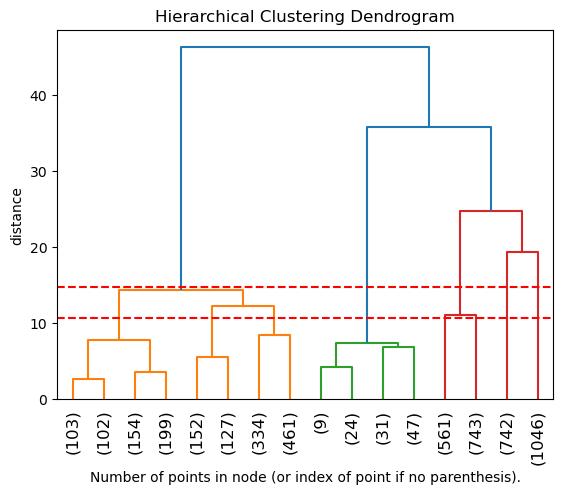

In [44]:
agg_cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(normed)
ax = plt.gca()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agg_cluster, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel('distance')
# note that these two red dashed lines are drawn manually, as we see that the gap between the two lines is larger than other gaps
plt.hlines(10.7, ax.get_xlim()[0], ax.get_xlim()[1], linestyle='dashed', color='r')
plt.hlines(14.8, ax.get_xlim()[0], ax.get_xlim()[1], linestyle='dashed', color='r')
plt.show()

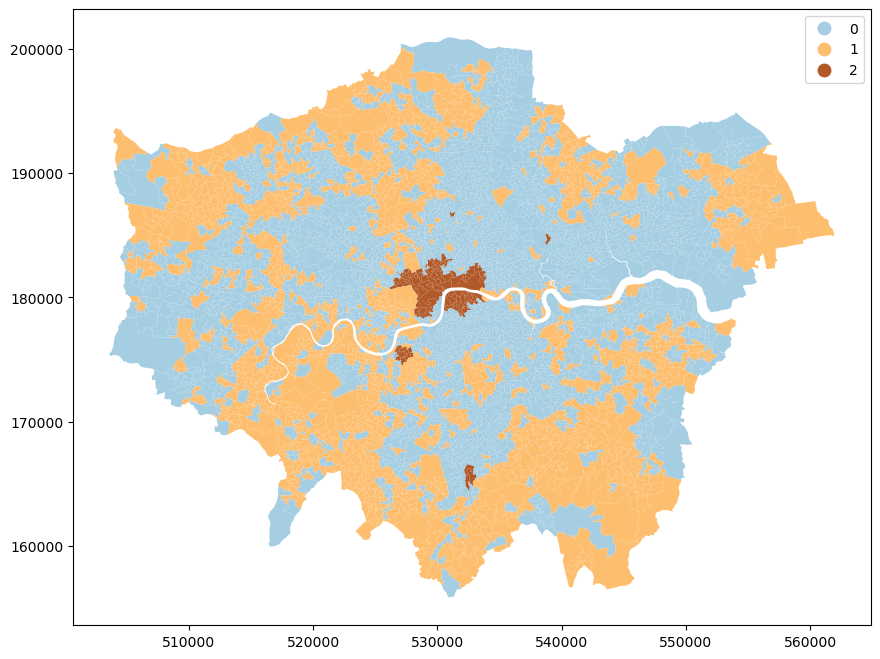

In [30]:
agg_cluster = AgglomerativeClustering(distance_threshold=None, n_clusters=3).fit(normed)
mapping_clusters(agg_cluster.labels_)
plt.savefig('hieclusters.png', dpi=150)

In [31]:
pd.Series(agg_cluster.labels_).value_counts()

0    3092
1    1632
2     111
Name: count, dtype: int64

You can find the mapping from the four clusters to the clusters in the above dendrogram, using the number of points in each cluster.

In the above dendrogram with the cutoff distance of around 12.5, the three clusters from left and right corresponds to Cluster 2, 1, and 0 in the map.